In [3]:
%load_ext autoreload
%autoreload 2

import torch
from diffusers import ControlNetModel

from text3d2video.artifacts.animation_artifact import AnimationArtifact
from text3d2video.attn_processor import MyAttnProcessor
from text3d2video.ipython_utils import display_ims
from text3d2video.pipelines.controlnet_pipeline import ControlNetPipeline
from text3d2video.rendering import render_depth_map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sd_repo = "runwayml/stable-diffusion-v1-5"
dtype = torch.float16
device = torch.device("cuda")

controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

controlnet = ControlNetModel.from_pretrained(controlnet_repo, torch_dtype=dtype).to(device)

pipe = ControlNetPipeline.from_pretrained(sd_repo, controlnet=controlnet, torch_dtype=dtype).to(
    device
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

[0, 25, 1, 7, 13, 19, 24]


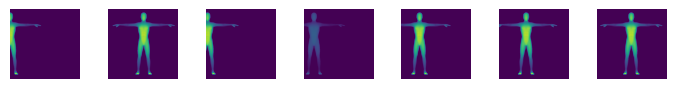

In [5]:
from text3d2video.util import ordered_sample


animation = AnimationArtifact.from_wandb_artifact_tag("mixamo-sideways:latest")

n_images = 4
# frames = [25] * n_images

n_true_imgs = 5
frames = [0, 25] + ordered_sample(range(1, 25), n_true_imgs)
n_images = len(frames)

print(frames)

meshes = animation.load_frames(frames)
cameras = animation.cameras(frames)

verts_uvs, faces_uvs = animation.texture_data()

depth_maps = render_depth_map(meshes, cameras)
display_ims(depth_maps)

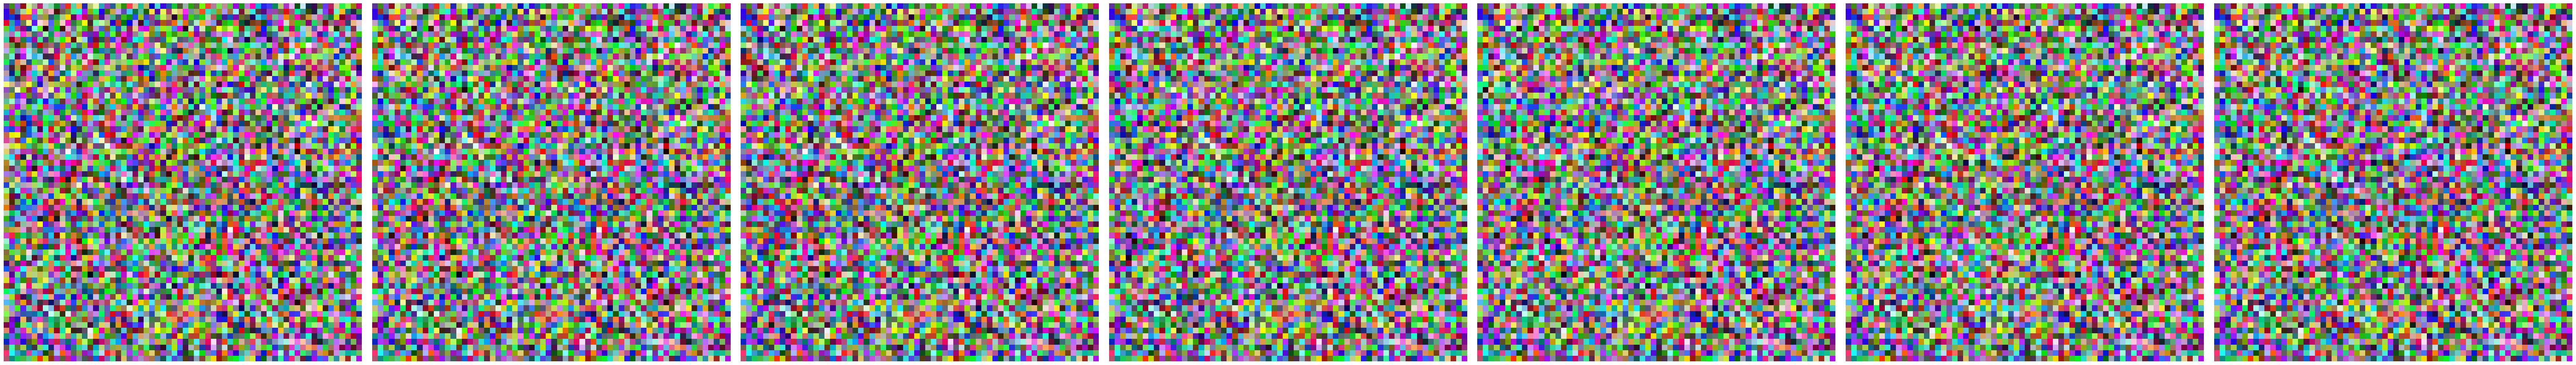

In [8]:
from text3d2video.uv_noise import prepare_uv_initialized_latents
import torchvision.transforms.functional as TF

latents = prepare_uv_initialized_latents(
    meshes, cameras, verts_uvs, faces_uvs, latent_texture_res=64
)

latents_ims = latents[:, 0:3, :, :].cpu()
latents_ims = [TF.to_pil_image(latent) for latent in latents_ims]
display_ims(latents_ims, scale=10)

100%|██████████| 31/31 [00:09<00:00,  3.32it/s]


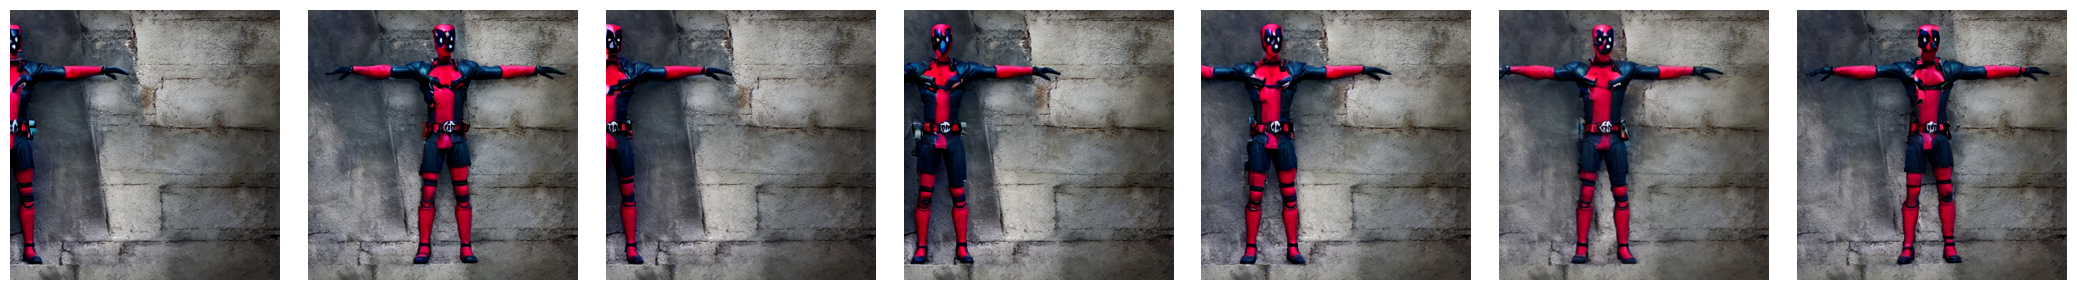

In [9]:
prompt = "Deadpool"

attn_processor = MyAttnProcessor(pipe.unet)
attn_processor.do_st_attention = False
attn_processor.do_fst_attention = True
pipe.unet.set_attn_processor(attn_processor)

gen = torch.Generator(device=device)
gen.manual_seed(0)

prompts = [prompt] * n_images

images = pipe(prompts, depth_maps, generator=gen, initial_latents=latents)
display_ims(images, scale=3)

In [471]:
attn_processor.saved_tensors

feature_ids = list(attn_processor.saved_tensors.keys())
tensors = list(set([k.split(",")[1] for k in feature_ids]))
layers = list(set([k.split(",")[0] for k in feature_ids]))

In [1]:
from math import sqrt

from einops import rearrange

from text3d2video.feature_visualization import reduce_feature_map

layer = layers[0]

idx = 0

# get key, query, value for frame 0
key = attn_processor.saved_tensors[f"{layer},key"][idx]
qry = attn_processor.saved_tensors[f"{layer},query"][idx]
val = attn_processor.saved_tensors[f"{layer},value"][idx]

layer_res = int(sqrt(qry.shape[0]))
chunk_size = 2

qry_square = rearrange(qry, "(h w) c -> c h w", h=layer_res)
key_square = rearrange(key, "(f h w) c -> c h (f w)", h=layer_res, w=layer_res)
val_square = rearrange(val, "(f h w) c -> c h (f w)", h=layer_res, w=layer_res)

qry_rgb = reduce_feature_map(qry_square.cpu())
key_rgb = reduce_feature_map(key_square.cpu())
val_rgb = reduce_feature_map(val_square.cpu())

display_ims([qry_rgb, key_rgb, val_rgb], scale=3)

NameError: name 'layers' is not defined